In [40]:
import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D
import pandas as pd
#from faerun import Faerun
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from plot_utils import *
from plot_utils import load_chid
import copy 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr
from utils import * 
import re 
params = {
    'font.size': 18,
    'legend.fontsize': 18,
    'text.usetex': False,
}
rcParams.update(params)

In [11]:
def optimization_vs_control_even_ranges(scores_1, scores_2):
    score_max, score_min = max(scores_1), min(scores_1)
    counts = []
    n_steps = 25
    step = (score_max - score_min)/n_steps
    control_scores = []
    optimization_scores = []
    control_spread = []
    scores_1 = np.array(scores_1)
    scores_2 = np.array(scores_2)
    for i in range(n_steps):
        lower_bound = i*step
        upper_bound = (i+1)*step
        indexes_low = np.where(scores_1>=lower_bound)[0]
        indexes_up = np.where(scores_1<upper_bound)[0]
        indexes_step = []
        for j in range(len(scores_1)):
            if j in indexes_low and j in indexes_up:
                indexes_step.append(j)
        indexes_step = np.array(indexes_step)           
        counts.append(len(indexes_step))
        try:
            control_scores.append(np.mean(scores_2[indexes_step]))
        except:
            control_scores.append([0])

        try:
            #optimization_scores.append(np.mean(scores_1[indexes_step]))
            optimization_scores.append(upper_bound)
        except:
            optimization_scores.append(-1)

        try:
            #optimization_scores.append(np.mean(scores_1[indexes_step]))
            control_spread.append(scores_2[indexes_step])
        except:
            control_spread.append([0])
    return control_spread, control_scores, optimization_scores

def fit_clfs(df, topliss_augmented=False, threshold=0.3, n_combinations=1, assay_name=""):
    #X = smiles
    
    #X_train, X_test, y_train, y_test = train_test_split(X, activity, test_size=0.33, random_state=0)
    #X_train = ecfp(X_train)
    #X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.5, random_state=1)
    
    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=0)


    df1, df2 = train_test_split(df_train, test_size=0.5, stratify=df_train['label'], random_state=0)
    X1 = np.array(list(df1['ecfp']))
    X2 = np.array(list(df2['ecfp']))

    y1 = np.array(list(df1['label']))
    y2 = np.array(list(df2['label']))

    del df1['ecfp']
    del df2['ecfp']
    X_test = list(df_test.smiles)
    balance = (np.mean(y1), np.mean(y2))

    # train classifiers and store them in dictionary
    clf_1 = RandomForestClassifier(
        n_estimators=100, random_state=0)

    clf_2 = RandomForestClassifier(
        n_estimators=100, random_state=0) #, max_depth=3

    clf_3 = RandomForestClassifier(
        n_estimators=100, random_state=1)

    

    clf_1.fit(X1, y1)
    clf_2.fit(X2, y2)
    clf_3.fit(X1, y1)
    
    test_scores = clf_1.predict_proba(ecfp(X_test))[:, 1]
    if topliss_augmented:
        augmented_smiles_test = []
        for i, s in enumerate(X_test):
            
            if test_scores[i]>threshold:
                augmented_smiles_test.extend(topliss_walk(s, n_combinations=n_combinations))
            else:
                augmented_smiles_test.extend([s])
        augmented_smiles_test = np.array(augmented_smiles_test)
        X_test = ecfp(augmented_smiles_test)
    else:
        X_test = ecfp(X_test)
        
    with open('data/' + assay_name + '_topliss.smi', 'w') as f:
        for smi in augmented_smiles_test:
            f.write("{}\n".format(smi))

    scores_1 = clf_1.predict_proba(X_test)[:, 1]
    scores_2 = clf_2.predict_proba(X_test)[:, 1]
    scores_3 = clf_3.predict_proba(X_test)[:, 1]

    return scores_1, scores_2, scores_3

# 1. DRD2

In [12]:
assay_file ='assays/processed/CHEMBL1909140.csv'
df = pd.read_csv(assay_file)
df['ecfp'] = ecfp(df.smiles)
scores_1_drd2, scores_2_drd2, scores_3_drd2 = fit_clfs(df, topliss_augmented=True, n_combinations=1, assay_name='drd2')

In [13]:
control_spread_drd2, control_scores_drd2, optimization_scores_drd2 = optimization_vs_control_even_ranges(scores_1_drd2, scores_2_drd2)
control_spread_drd2_mc, control_scores_drd2_mc, optimization_scores_drd2_mc = optimization_vs_control_even_ranges(scores_1_drd2, scores_3_drd2)

# 2. EGFR

In [14]:
assay_file ='assays/processed/CHEMBL1909203.csv'
df = pd.read_csv(assay_file)
df['ecfp'] = ecfp(df.smiles)
scores_1_egfr, scores_2_egfr, scores_3_egfr = fit_clfs(df, topliss_augmented=True, n_combinations=1, assay_name='egfr')

In [15]:
control_spread_egfr, control_scores_egfr, optimization_scores_egfr = optimization_vs_control_even_ranges(scores_1_egfr, scores_2_egfr)
control_spread_egfr_mc, control_scores_egfr_mc, optimization_scores_egfr_mc = optimization_vs_control_even_ranges(scores_1_egfr, scores_3_egfr)

# 3. JAK2

In [16]:
assay_file ='assays/processed/CHEMBL3888429.csv'
df = pd.read_csv(assay_file)
df['ecfp'] = ecfp(df.smiles)
scores_1_jak2, scores_2_jak2, scores_3_jak2 = fit_clfs(df, topliss_augmented=True, n_combinations=1, assay_name='jak2')

In [17]:
control_spread_jak2, control_scores_jak2, optimization_scores_jak2 = optimization_vs_control_even_ranges(scores_1_jak2, scores_2_jak2)
control_spread_jak2_mc, control_scores_jak2_mc, optimization_scores_jak2_mc = optimization_vs_control_even_ranges(scores_1_jak2, scores_3_jak2)

# 4. ALDH1

In [19]:
df = pd.read_csv("assays/processed/210415_LIT_PCBA_ALDH1_Best_AB_sets.csv")
in_set_A = np.where(df['in_set_A']==1)[0]
in_set_B = np.where(df['in_set_B']==1)[0]
smiles = df["SMILES"]
activity = df["Act"]
index_test = []
for i in range(len(smiles)):
    if i not in in_set_A and i not in in_set_B:
        index_test.append(i)
        
in_test = np.array(index_test)
X1 = np.array(ecfp(smiles[in_set_A]))
X2 = np.array(ecfp(smiles[in_set_B]))
X_test = np.array(ecfp(smiles[in_test]))
    
augmented_smiles_test = []
for i, s in enumerate(smiles[in_test]):
    augmented_smiles_test.extend(topliss_walk(s, n_combinations=2))
augmented_smiles_test = np.array(augmented_smiles_test)
X_test = np.array(ecfp(augmented_smiles_test))

with open('data/aldh1_topliss.smi', 'w') as f:
    for smi in augmented_smiles_test:
        f.write("{}\n".format(smi))
        
y1 = np.array(activity[in_set_A])
y2 = np.array(activity[in_set_B])

clf_1 = RandomForestClassifier(
    n_estimators=100, random_state=0)

clf_2 = RandomForestClassifier(
    n_estimators=100, random_state=0) #, max_depth=3

clf_3 = RandomForestClassifier(
    n_estimators=100, random_state=1)

clf_1.fit(X1, y1)
clf_2.fit(X2, y2)
clf_3.fit(X1, y1)


scores_1_aldh1 = clf_1.predict_proba(X_test)[:, 1]
scores_2_aldh1 = clf_2.predict_proba(X_test)[:, 1]
scores_3_aldh1 = clf_3.predict_proba(X_test)[:, 1]

In [20]:
control_spread_aldh1, control_scores_aldh1, optimization_scores_aldh1 = optimization_vs_control_even_ranges(scores_1_aldh1, scores_2_aldh1)
control_spread_aldh1_mc, control_scores_aldh1_mc, optimization_scores_aldh1_mc = optimization_vs_control_even_ranges(scores_1_aldh1, scores_3_aldh1)

# 5. JAK2 cleaned

In [21]:
assay_file ='assays/processed/CHEMBL3888429.csv'
df = pd.read_csv(assay_file)
df['ecfp'] = ecfp(df.smiles)

smiles = np.array(list(df.smiles))
activity = np.array(df.label)


X = ecfp(smiles)
X_train, X_test, y_train, y_test = train_test_split(smiles, activity, test_size=0.1, random_state=0)
#X_train = ecfp(X_train)
X1, X2, y1, y2 = train_test_split(ecfp(X_train), y_train, test_size=0.5, random_state=0)

clf_1 = RandomForestClassifier(
    n_estimators=200, random_state=0, min_samples_leaf=3)

clf_2 = RandomForestClassifier(
    n_estimators=200, random_state=0, min_samples_leaf=3) #, max_depth=3

clf_3 = RandomForestClassifier(
    n_estimators=200, random_state=1, min_samples_leaf=3)

clf_1.fit(X1, y1)
clf_2.fit(X2, y2)
clf_3.fit(X1, y1)

    
augmented_smiles_test = []
for i, s in enumerate(X_test):
    augmented_smiles_test.extend(topliss_walk(s, n_combinations=1))
augmented_smiles_test = np.array(augmented_smiles_test)
X_test = np.array(ecfp(augmented_smiles_test))

scores_1_jak2_cleaned = clf_1.predict_proba(X_test)[:, 1]
scores_2_jak2_cleaned = clf_2.predict_proba(X_test)[:, 1]
scores_3_jak2_cleaned = clf_3.predict_proba(X_test)[:, 1]

In [22]:
control_spread_jak2_cleaned, control_scores_jak2_cleaned, optimization_scores_jak2_cleaned = optimization_vs_control_even_ranges(scores_1_jak2_cleaned, scores_2_jak2_cleaned)
control_spread_jak2_cleaned_mc, control_scores_jak2_cleaned_mc, optimization_scores_jak2_cleaned_mc = optimization_vs_control_even_ranges(scores_1_jak2_cleaned, scores_3_jak2_cleaned)

# Data control vs optimization score analysis

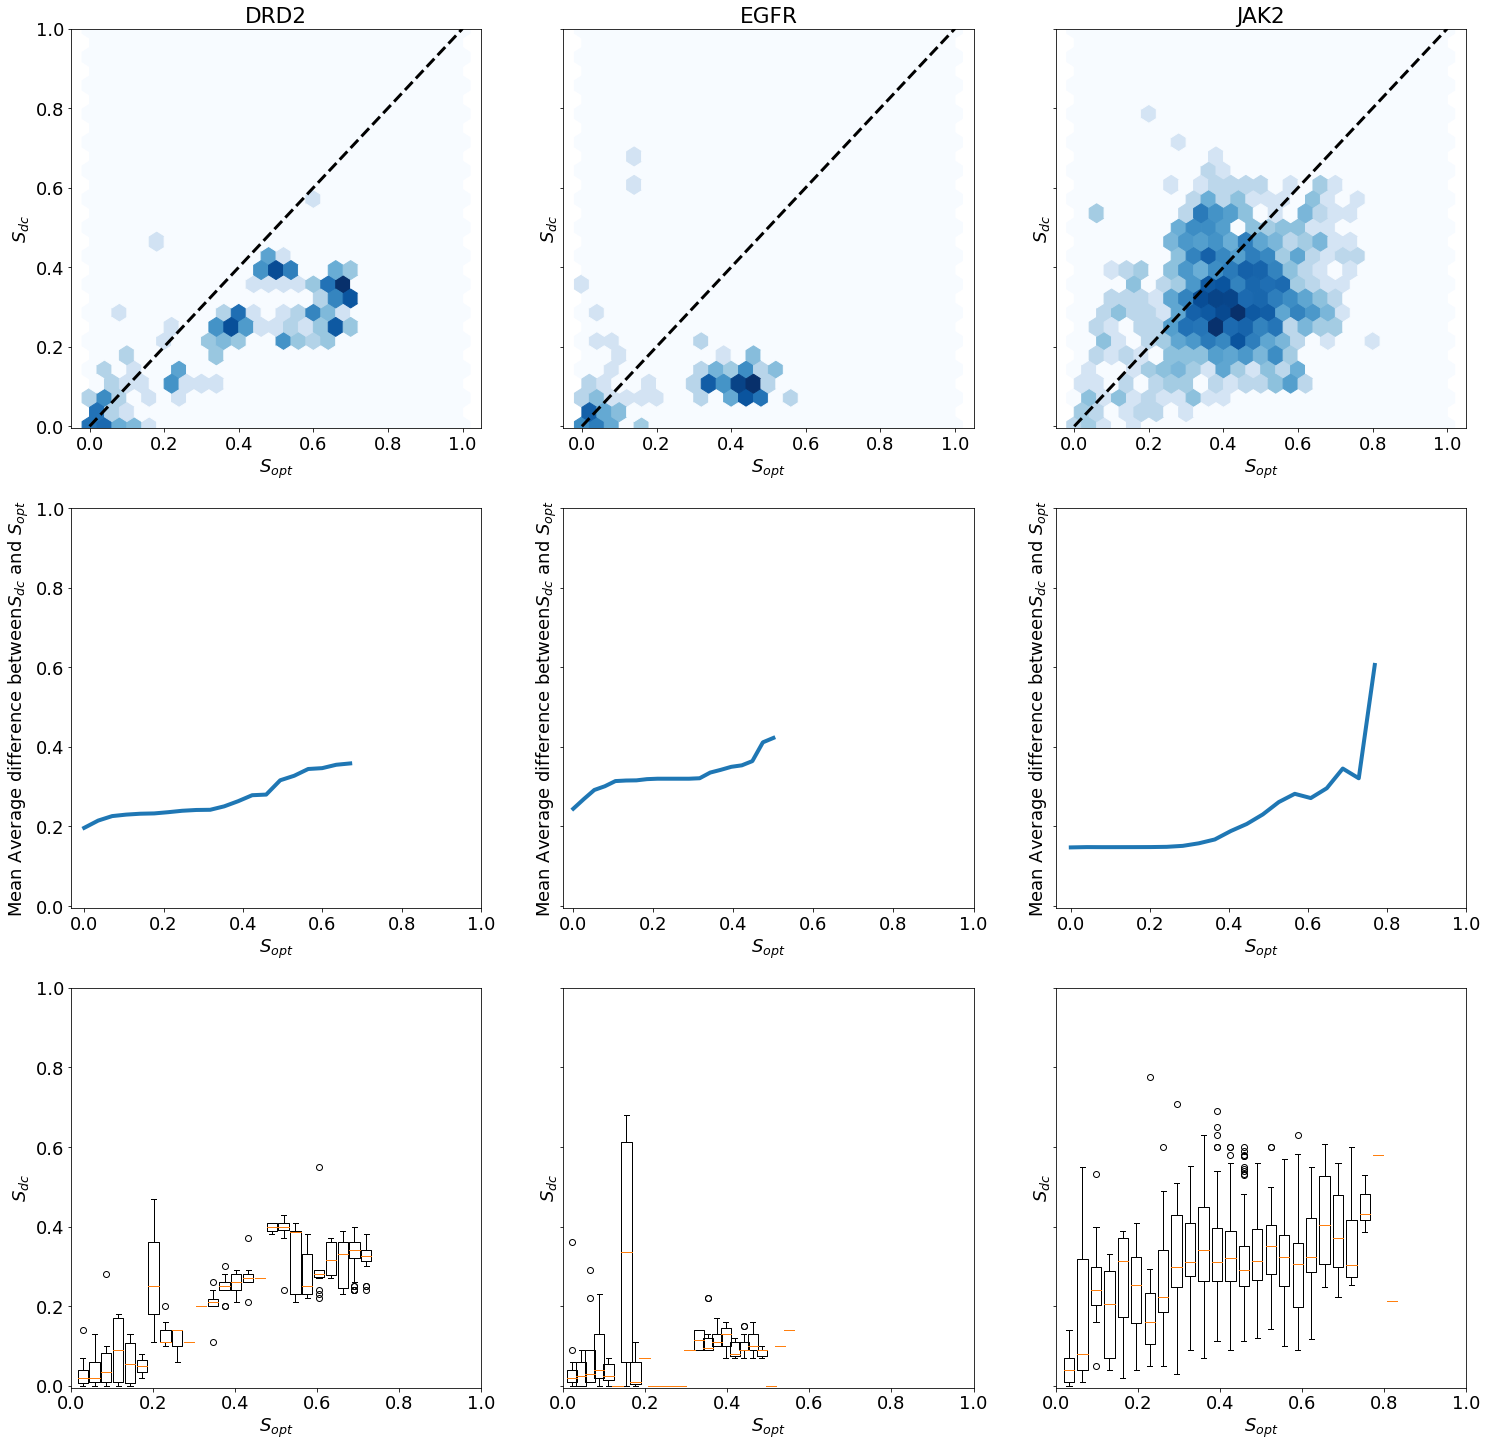

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25), sharey=True)
scores_1 = [scores_1_drd2, scores_1_egfr, scores_1_jak2]
scores_2 = [scores_2_drd2, scores_2_egfr, scores_2_jak2]
targets = ['DRD2', 'EGFR', 'JAK2']
for i, target in enumerate(targets):
    ax = axes[0][i]
    xpoints = ypoints = (0, 1)
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
   
    ax.hexbin(scores_1[i], scores_2[i], extent=[0, 1, 0, 1], gridsize=25, cmap='Blues', bins='log')
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{dc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_title(target)
    
for i, target in enumerate(targets):
    ax = axes[1][i]
    ax.plot(np.linspace(0,max(scores_1[i])-0.05 , 20), [mean_absolute_error(scores_1[i][np.where(scores_1[i]>x)], scores_2[i][np.where(scores_1[i]>x)]) for x in np.linspace(0,max(scores_1[i])-0.05 , 20)], linewidth=4)
    plt.ylim(-0.005, 1)
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_ylabel("Mean Average difference between" + r'$S_{dc}$' + ' and '+ r'$S_{opt}$')
    
    ticks = np.linspace(0, 1, 6)
    xticks = ticks
    
    xticklabels = [str(x)[:3] for x in np.linspace(0, 1, 6)]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_title(target)
    
control_spread_targets = [control_spread_drd2, control_spread_egfr, control_spread_jak2]
optimisation_targets = [optimization_scores_drd2, optimization_scores_egfr, optimization_scores_jak2]

for i, target in enumerate(targets):
    ax = axes[2][i]
    ax.boxplot(control_spread_targets[i], positions = optimisation_targets[i], widths=0.025)
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{dc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_xlim(0, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    plt.savefig('figures/original_datasets_analysis.pdf', bbox_inches='tight')

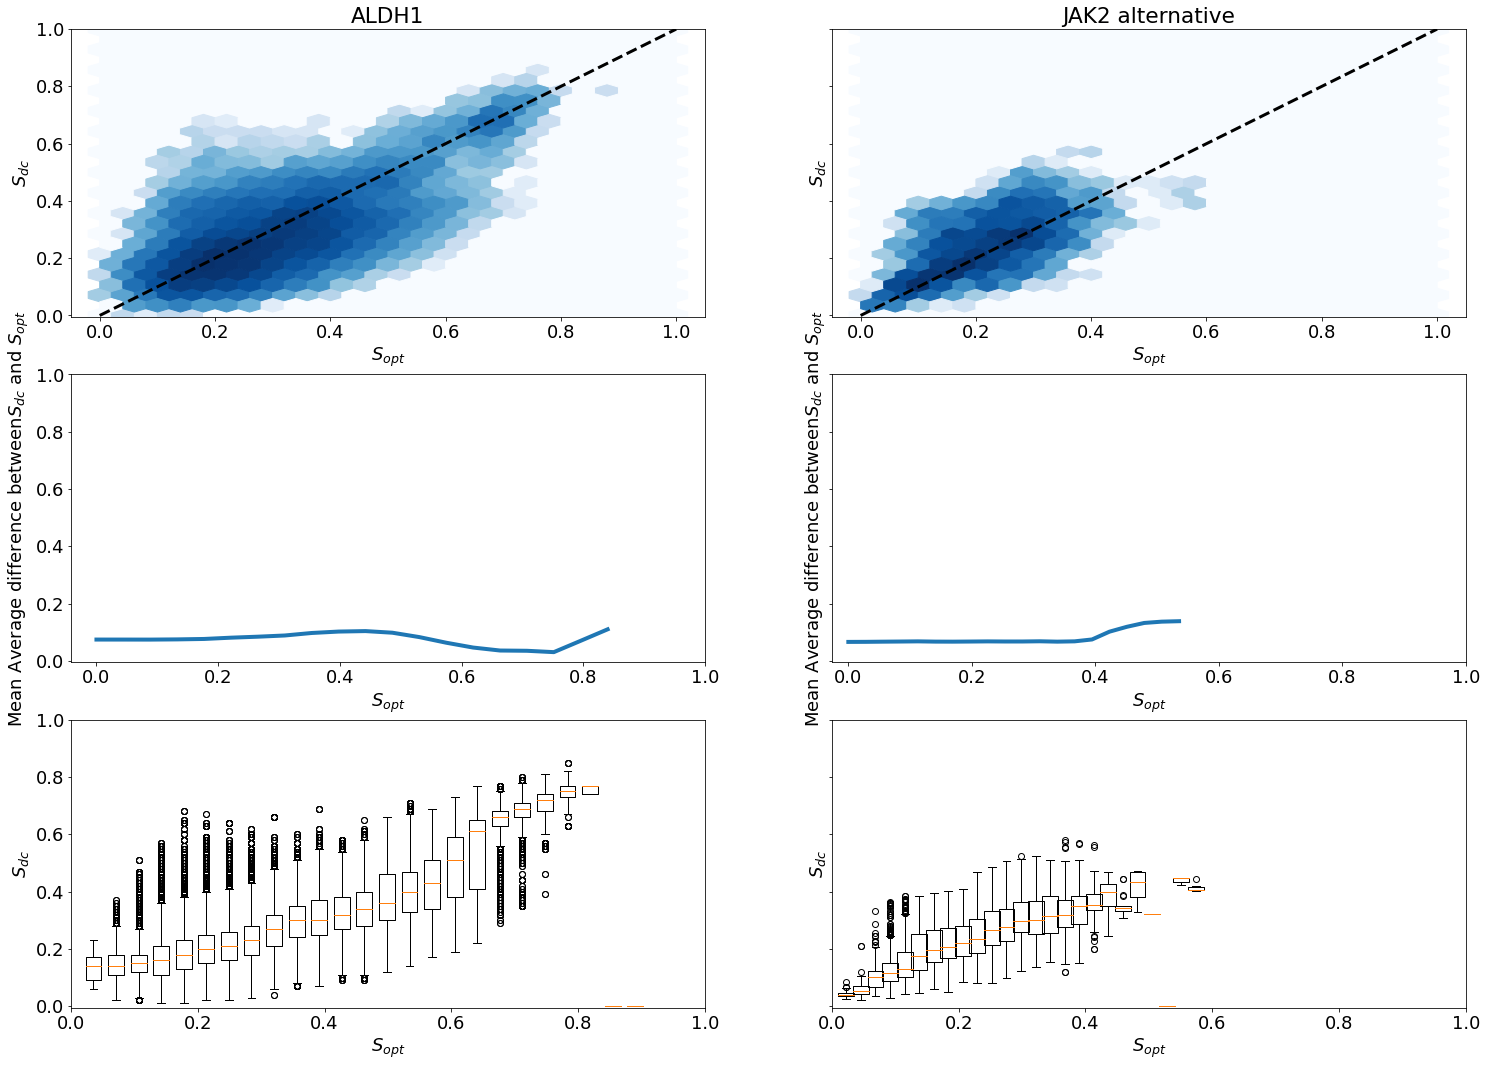

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 18), sharey=True)

scores_1 = [scores_1_aldh1, scores_1_jak2_cleaned]
scores_2 = [scores_2_aldh1, scores_2_jak2_cleaned]
targets = ['ALDH1', 'JAK2 alternative']

for i, target in enumerate(targets):
    ax = axes[0][i]
    xpoints = ypoints = (0, 1)
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
   
    ax.hexbin(scores_1[i], scores_2[i], extent=[0, 1, 0, 1], gridsize=25, cmap='Blues', bins='log')
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{dc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_title(target)
    
for i, target in enumerate(targets):
    ax = axes[1][i]
    ax.plot(np.linspace(0,max(scores_1[i])-0.05 , 20), [mean_absolute_error(scores_1[i][np.where(scores_1[i]>x)], scores_2[i][np.where(scores_1[i]>x)]) for x in np.linspace(0,max(scores_1[i])-0.05 , 20)], linewidth=4)
    plt.ylim(-0.005, 1)
    ax.set_ylabel("Mean Average difference between" + r'$S_{dc}$' + ' and '+ r'$S_{opt}$')
    ax.set_xlabel(r'$S_{opt}$')
    
    ticks = np.linspace(0, 1, 6)
    xticks = ticks
    
    xticklabels = [str(x)[:3] for x in np.linspace(0, 1, 6)]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_title(target)
    
control_spread_targets = [control_spread_aldh1, control_spread_jak2_cleaned]
optimisation_targets = [optimization_scores_aldh1, optimization_scores_jak2_cleaned,]

for i, target in enumerate(targets):
    ax = axes[2][i]
    ax.boxplot(control_spread_targets[i], positions = optimisation_targets[i], widths=0.025)
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{dc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_xlim(0, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    plt.savefig('figures/new_datasets_analysis.pdf', bbox_inches='tight')

# Model control vs optimization score analysis

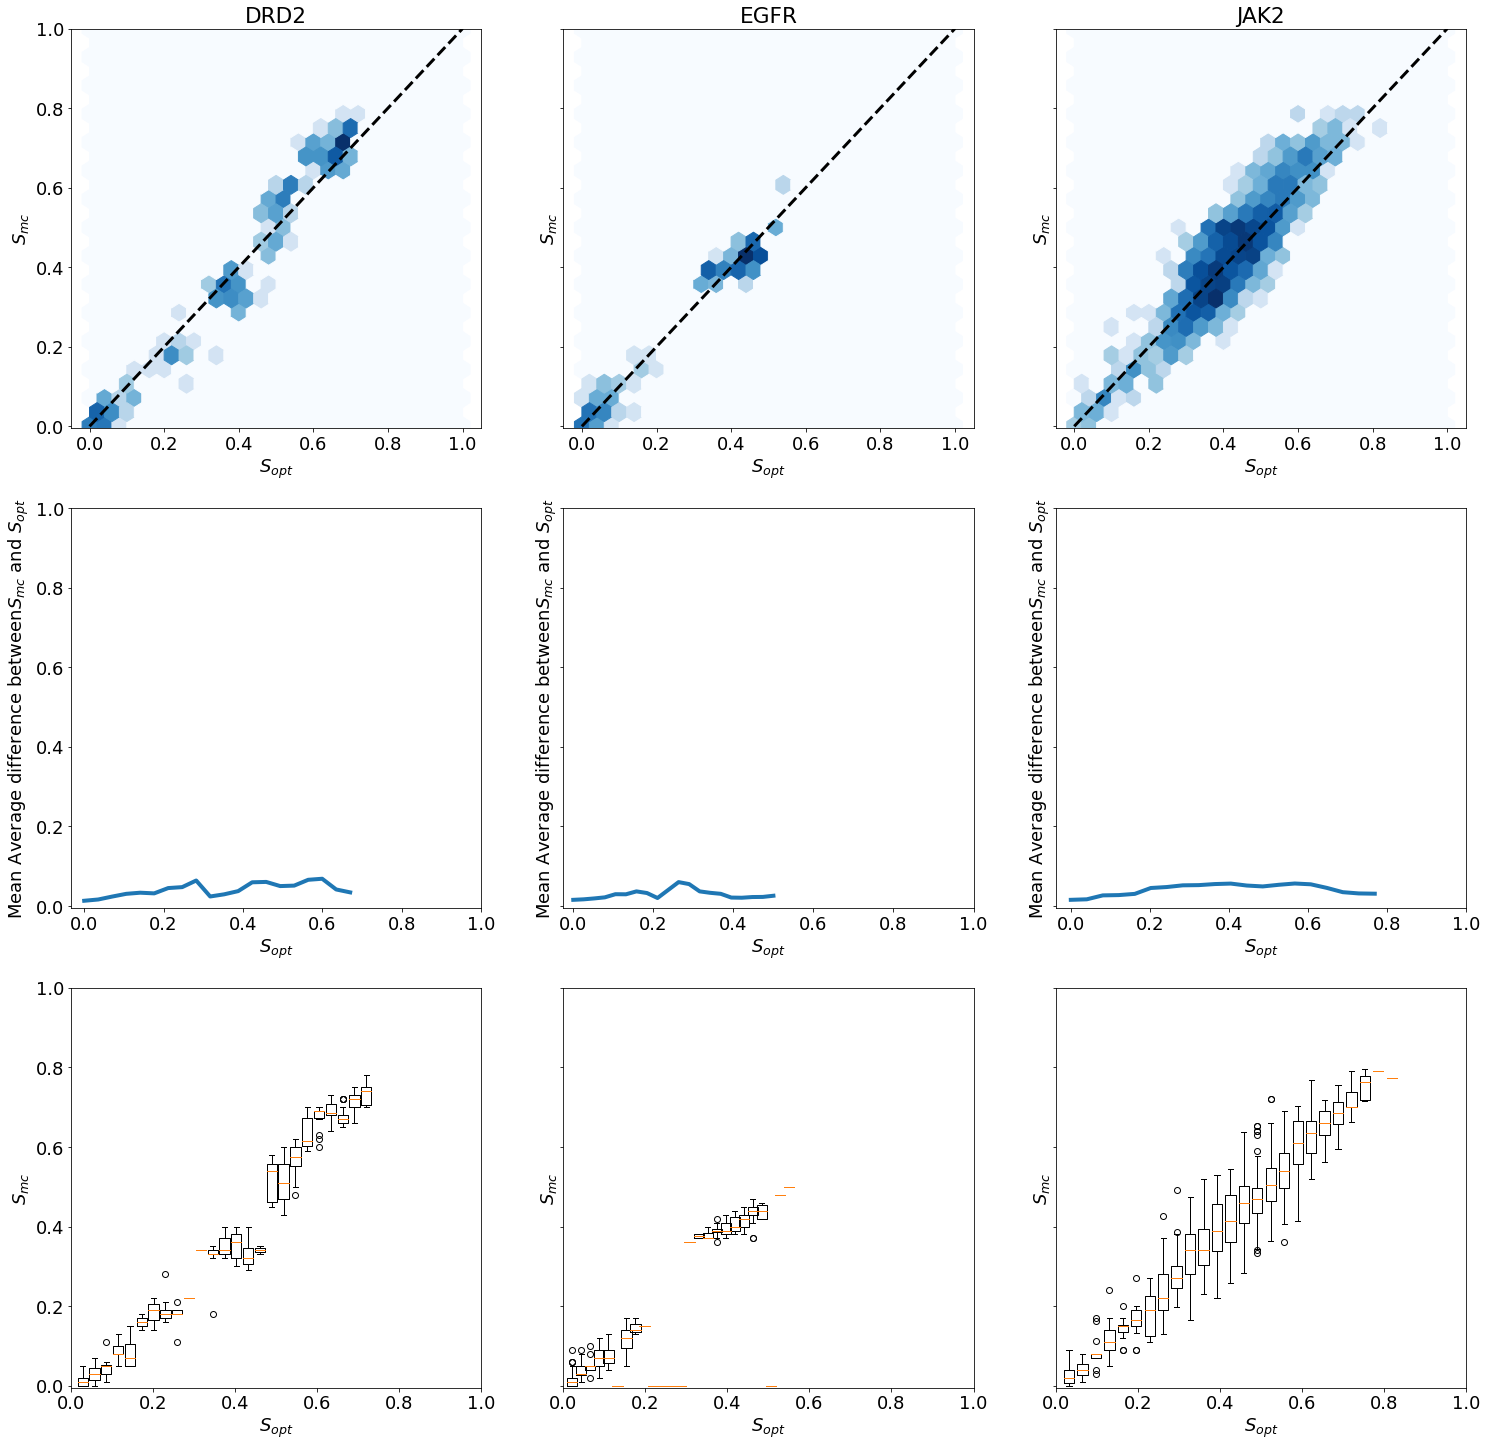

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25), sharey=True)
scores_1 = [scores_1_drd2, scores_1_egfr, scores_1_jak2]
scores_2 = [scores_3_drd2, scores_3_egfr, scores_3_jak2]
targets = ['DRD2', 'EGFR', 'JAK2']
for i, target in enumerate(targets):
    ax = axes[0][i]
    xpoints = ypoints = (0, 1)
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
   
    ax.hexbin(scores_1[i], scores_2[i], extent=[0, 1, 0, 1], gridsize=25, cmap='Blues', bins='log')
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{mc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_title(target)
    
for i, target in enumerate(targets):
    ax = axes[1][i]
    ax.plot(np.linspace(0,max(scores_1[i])-0.05 , 20), [mean_absolute_error(scores_1[i][np.where(np.abs(scores_1[i]-x)<0.05)], scores_2[i][np.where(np.abs(scores_1[i]-x)<0.05)]) for x in np.linspace(0,max(scores_1[i])-0.05 , 20)], linewidth=4)
    plt.ylim(-0.005, 1)
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_ylabel("Mean Average difference between" + r'$S_{mc}$' + ' and '+ r'$S_{opt}$')
    
    ticks = np.linspace(0, 1, 6)
    xticks = ticks
    
    xticklabels = [str(x)[:3] for x in np.linspace(0, 1, 6)]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_title(target)
    
control_spread_targets = [control_spread_drd2_mc, control_spread_egfr_mc, control_spread_jak2_mc]
optimisation_targets = [optimization_scores_drd2_mc, optimization_scores_egfr_mc, optimization_scores_jak2_mc]

for i, target in enumerate(targets):
    ax = axes[2][i]
    ax.boxplot(control_spread_targets[i], positions = optimisation_targets[i], widths=0.025)
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{mc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_xlim(0, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    plt.savefig('figures/original_datasets_analysis_model_control.pdf', bbox_inches='tight')

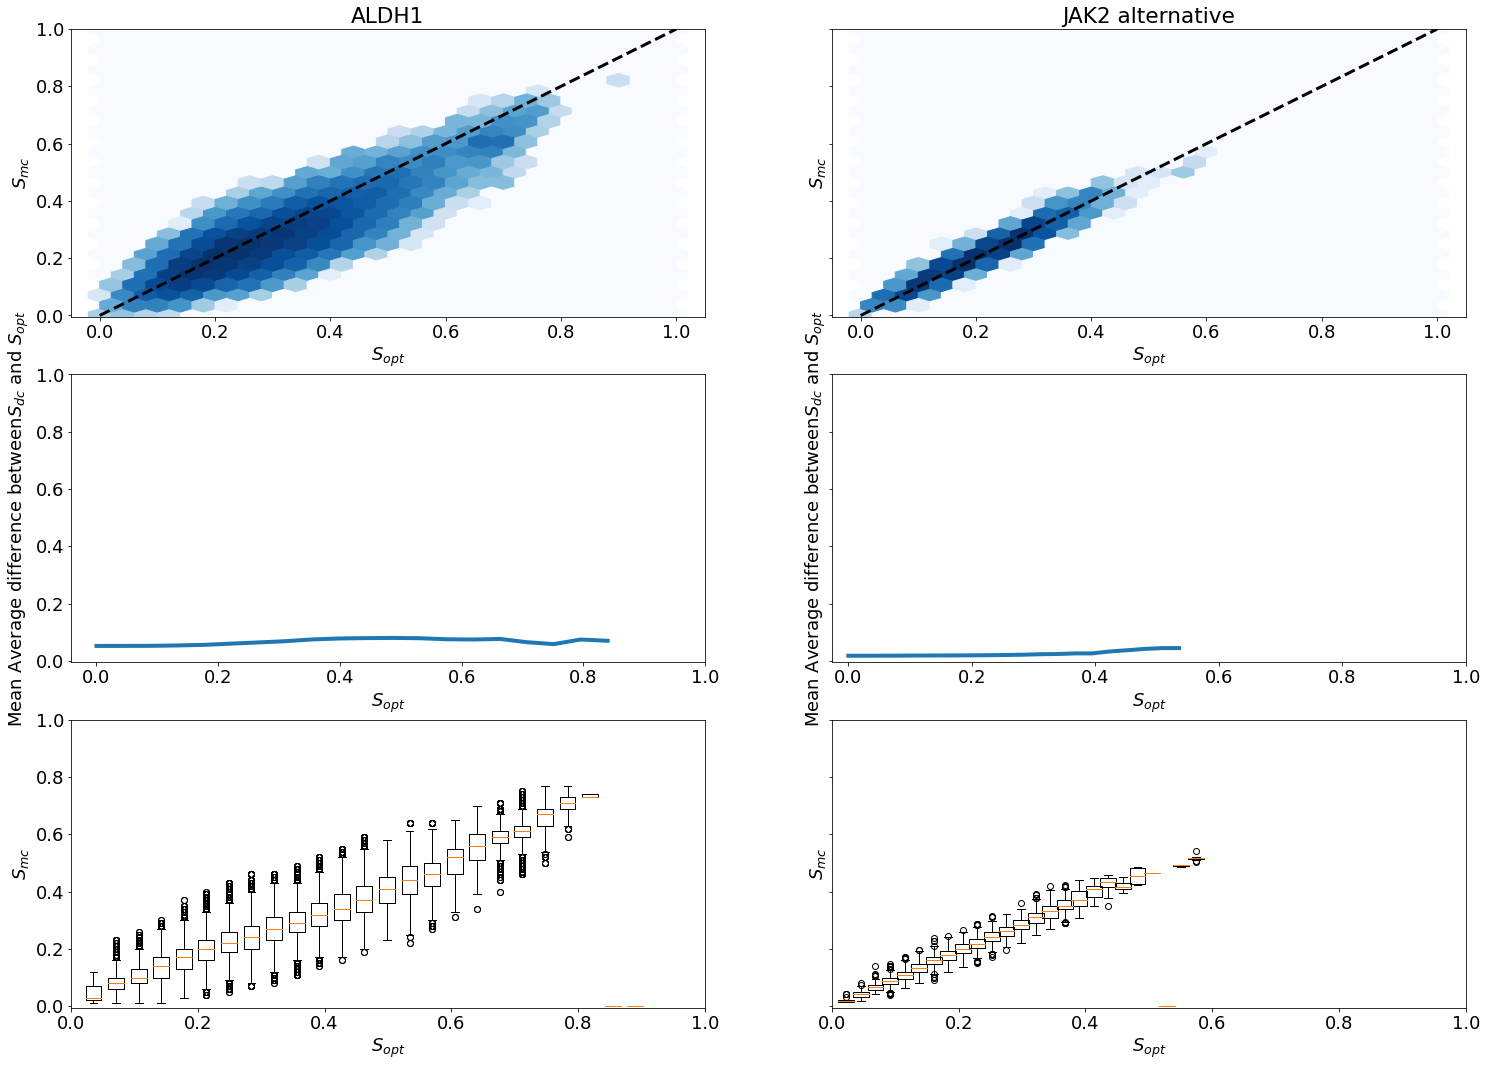

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 18), sharey=True)

scores_1 = [scores_1_aldh1, scores_1_jak2_cleaned]
scores_2 = [scores_3_aldh1, scores_3_jak2_cleaned]
targets = ['ALDH1', 'JAK2 alternative']

for i, target in enumerate(targets):
    ax = axes[0][i]
    xpoints = ypoints = (0, 1)
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
   
    ax.hexbin(scores_1[i], scores_2[i], extent=[0, 1, 0, 1], gridsize=25, cmap='Blues', bins='log')
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{mc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_title(target)
    
for i, target in enumerate(targets):
    ax = axes[1][i]
    ax.plot(np.linspace(0,max(scores_1[i])-0.05 , 20), [mean_absolute_error(scores_1[i][np.where(scores_1[i]>x)], scores_2[i][np.where(scores_1[i]>x)]) for x in np.linspace(0,max(scores_1[i])-0.05 , 20)], linewidth=4)
    plt.ylim(-0.005, 1)
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_ylabel("Mean Average difference between" + r'$S_{dc}$' + ' and ' + r'$S_{opt}$')
    
    ticks = np.linspace(0, 1, 6)
    xticks = ticks
    
    xticklabels = [str(x)[:3] for x in np.linspace(0, 1, 6)]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_title(target)
    
control_spread_targets = [control_spread_aldh1_mc, control_spread_jak2_cleaned_mc]
optimisation_targets = [optimization_scores_aldh1, optimization_scores_jak2_cleaned,]

for i, target in enumerate(targets):
    ax = axes[2][i]
    ax.boxplot(control_spread_targets[i], positions = optimisation_targets[i], widths=0.025)
    plt.ylim(-0.005, 1)
    ax.set_ylabel(r'$S_{mc}$')
    ax.set_xlabel(r'$S_{opt}$')
    ax.set_xlim(0, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    plt.savefig('figures/new_datasets_analysis_model_control.pdf', bbox_inches='tight')